In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import random
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pylab
import tensorflow as tf
# import cv2
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
# define the path to the annotation file corresponding to the images you want to work with
dataDir='/Users/kyle/Repositories/coco'
trainData='person_keypoints_train2014'
valData='person_keypoints_val2014'
testData='image_info_test-dev2015'

annTrainFile='{}/annotations/{}.json'.format(dataDir,trainData)
annValFile='{}/annotations/{}.json'.format(dataDir,valData)
annTestFile='{}/annotations/{}.json'.format(dataDir,testData)

imageTrainFolder='{}/images/{}'.format(dataDir,trainData)
imageValFolder='{}/images/{}'.format(dataDir,valData)
imageTestFolder='{}/images/{}'.format(dataDir,testData)

print(annTrainFile)
print(annValFile)
print(annTestFile)
print(imageTrainFolder)
print(imageValFolder)
print(imageTestFolder)

# initialize a coco object
coco = COCO(annTrainFile)

# get all images containing the 'person' category
catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds)

/Users/kyle/Repositories/coco/annotations/person_keypoints_train2014.json
/Users/kyle/Repositories/coco/annotations/person_keypoints_val2014.json
/Users/kyle/Repositories/coco/annotations/image_info_test-dev2015.json
/Users/kyle/Repositories/coco/images/person_keypoints_train2014
/Users/kyle/Repositories/coco/images/person_keypoints_val2014
/Users/kyle/Repositories/coco/images/image_info_test-dev2015
loading annotations into memory...
Done (t=7.63s)
creating index...
index created!


In [3]:
# Initialize dataset

baseDir = '/Users/kyle/Repositories/coco'
imageTrainDir = 'train2014'
annTrainDir = 'person_keypoints_val2014'
imagePath = '{}/images/{}'.format(baseDir,imageTrainDir)
annPath = '{}/annotations/{}'.format(baseDir,annTrainDir)

filenames = tf.constant(['{}/COCO_train2014_{:0>12}.jpg'.format(imagePath,img_ID) for img_ID in imgIds])
imgID_tensor = tf.constant(imgIds)

precision = tf.float32

In [4]:
def getBiggestBox(image, imgID, coco=coco):
    anns = coco.loadAnns(coco.getAnnIds(imgID,catIds=[1],iscrowd=None))
    ann_biggest = anns[0]
    for ann in anns:
        if ann['area'] > ann_biggest['area']:
            ann_biggest = ann
            
    bbox = np.array(np.floor(ann_biggest['bbox']),dtype=int)
    cropped_image = image[bbox[1]:(bbox[1]+bbox[3]),bbox[0]:(bbox[0]+bbox[2]),:]
    return cropped_image, imgID, bbox

In [5]:
def _extractAnnotations(filename, imgID, coco=coco):
    anns = coco.loadAnns(coco.getAnnIds(imgID,catIds=[1],iscrowd=None))
    
#     for ann in anns:
#         ann['segmentation'] = (np.array(ann['segmentation'])*scale).tolist()
    
    bbox_tensor = np.array([ann['bbox'] for ann in anns],dtype=np.float32)
    keypoints_tensor = np.array([np.reshape(ann['keypoints'],(-1,3)) for ann in anns], dtype=np.float32)
    crowd_tensor = np.array([[ann['iscrowd']] for ann in anns], dtype=np.float32)
    area_tensor = np.array([[ann['area']] for ann in anns], dtype=np.float32)
    mask_tensor = np.array([[coco.annToMask(ann) for ann in anns]] ,dtype=np.uint8)
    
    return filename, bbox_tensor, keypoints_tensor, crowd_tensor, area_tensor, mask_tensor

In [6]:
# def getImageTraining(filename, imgID, smallest_side=224.0):
def getImageTraining(filename, bbox_tensor, keypoints_tensor, crowd_tensor, 
                     area_tensor, mask_tensor, smallest_side=224.0):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=0)          # (1)
#     image = tf.cast(image_decoded, tf.float32)
    image = image_decoded

    smallest_side = 224.0
    height, width = tf.shape(image)[0], tf.shape(image)[1]
    height = tf.to_float(height)
    width = tf.to_float(width)

    scale = tf.cond(tf.greater(height, width),
                    lambda: smallest_side / width,
                    lambda: smallest_side / height)
    new_height = tf.maximum(tf.to_int32(height * scale), tf.to_int32(smallest_side))
    new_width = tf.maximum(tf.to_int32(width * scale), tf.to_int32(smallest_side))

    resized_image = tf.image.resize_images(image, [new_height, new_width],tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # (2)
    
    # resize label tensors:
    bbox_tensor = tf.multiply(bbox_tensor,scale)
    pts, labels = tf.split(keypoints_tensor,[2,1],axis=2)
    pts = tf.multiply(pts,scale)
    keypoints_tensor = tf.concat([pts,labels],axis=2)
    area_tensor = area_tensor*scale*scale
    mask_tensor = tf.transpose(mask_tensor,[1,2,3,0])
    mask_tensor = tf.image.resize_images(mask_tensor, [new_height, new_width],tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return resized_image, bbox_tensor, keypoints_tensor, crowd_tensor, area_tensor, mask_tensor

In [7]:
def training_preprocess(image, bbox_tensor, keypoints_tensor, crowd_tensor, area_tensor, mask_tensor):
    # pad image
    H = 224
    W = 224
    dH = tf.shape(image)[0] - H + 1
    dW = tf.shape(image)[1] - W + 1
    
    offset_height = tf.random_uniform((1,),minval=0,maxval=dH,dtype=tf.int32)
    offset_width = tf.random_uniform((1,),minval=0,maxval=dW,dtype=tf.int32)

#     cropped_image = tf.random_crop(image,[H,W,3])
    cropped_image = image
    
    return cropped_image, bbox_tensor, keypoints_tensor, crowd_tensor, area_tensor, mask_tensor

In [8]:
myDataset = tf.contrib.data.Dataset.from_tensor_slices((filenames,imgID_tensor))

myDataset = myDataset.map(lambda filename, imgID: tf.py_func(
        _extractAnnotations, [filename, imgID], [filename.dtype, precision, precision, precision, precision, tf.uint8]))
myDataset = myDataset.map(getImageTraining)
# myDataset = myDataset.map(lambda image, imgID: tf.py_func(
#         _extractAnnotations, [image, imgID], [image.dtype, precision, precision, precision, precision, tf.bool]))
myDataset = myDataset.map(training_preprocess)

# batched_Dataset = myDataset.batch(4) # must resize images to make them match
# batched_Dataset = batched_Dataset.shuffle(buffer_size=10000)

iterator = myDataset.make_one_shot_iterator()
next_element = iterator.get_next()
myDataset

<MapDataset shapes: ((?, ?, ?), <unknown>, <unknown>, <unknown>, <unknown>, (?, ?, ?, ?)), types: (tf.uint8, tf.float32, tf.float32, tf.float32, tf.float32, tf.uint8)>

In [9]:
sess = tf.Session()

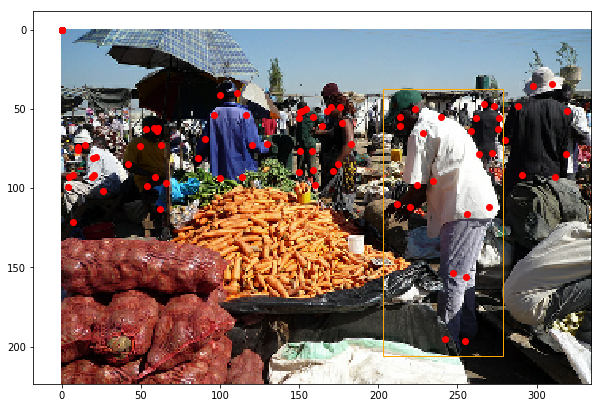

((14, 4), (14, 17, 3), (14, 224, 335, 1), (14, 1), (14, 1))

In [10]:
trainingImage, bbox, kpts, crowd, area, mask = sess.run(next_element)
ax = plt.subplot(1,1,1)
plt.imshow(trainingImage)
plt.scatter(kpts[:,:,0],kpts[:,:,1],c="r")
ax.add_patch(patches.Rectangle((bbox[0,0],bbox[0,1]),bbox[0,2],bbox[0,3],fill=False,edgecolor="orange"))
plt.show()

# COLOR CHANGE CAUSED BY CASTING TO FLOAT
bbox.shape, kpts.shape, mask.shape, crowd.shape, area.shape

In [15]:
def crop_to_largest_instance(image, imgID, coco=coco, D=224.0):
    anns = coco.loadAnns(coco.getAnnIds(imgID,catIds=[1],iscrowd=None))
    ann = max([ann for ann in anns], key=lambda item:item['area']) # extract annotation for biggest instance
    bbox = np.array(np.floor(ann['bbox']),dtype=int)
    sideLength = np.max(bbox[2:]) # largest side
    center = (np.floor(bbox[0]+bbox[2]/2.0), np.floor(bbox[1]+bbox[3]/2.0))
    corner1 = np.minimum(np.maximum(np.array(center - sideLength/2.0,dtype=int), 0), np.flip(image.shape[:2],axis=0))
    corner2 = np.minimum(np.maximum(np.array(center + sideLength/2.0,dtype=int), 0), np.flip(image.shape[:2],axis=0))
    i_shape = corner2 - corner1
    d_shape = sideLength - i_shape
    scale = np.array(D/sideLength)
    cropped_image = image[corner1[1]:corner2[1], corner1[0]:corner2[0],:]
    
    dX = np.floor(d_shape/2.0).astype(int)
    dY = np.ceil(d_shape/2.0).astype(int)
    keypoints = np.reshape(ann['keypoints'],(-1,3)) - np.array([corner1[0]-dX[0],corner1[1]-dX[1],0])
    inbounds = (keypoints[:,0] >= 0)*(keypoints[:,0] <= sideLength)*(keypoints[:,1] >= 0)*(keypoints[:,1] <= sideLength)
    keypoints[inbounds,2] = 2
    keypoints[inbounds,0] = 0
    keypoints[inbounds,1] = 1
    padded_image = np.dstack([np.lib.pad(
                cropped_image[:,:,i],((dX[1],dY[1]),
                                      (dX[0],dY[0])),mode='constant') for i in range(3)])

    return padded_image, cropped_image, keypoints, scale

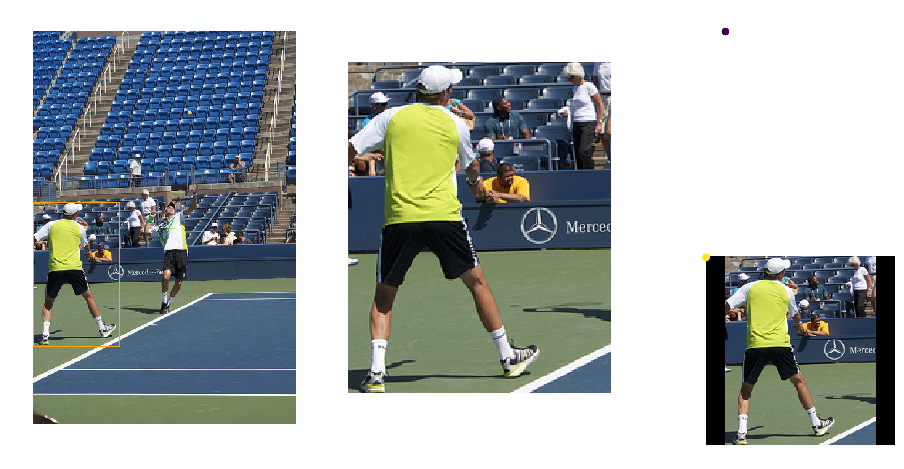

In [20]:
# load and display image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0] # select a random image

I = io.imread('http://mscoco.org/images/%d'%(img['id'])) # use url to load image
I3, I2, kpts, scale = crop_to_largest_instance(I,img['id'])

# Display image
plt.figure(figsize=[16,8])
anns = coco.loadAnns(coco.getAnnIds(img['id'],catIds=[1],iscrowd=None))
ann = max([ann for ann in anns], key=lambda item:item['area']) # extract annotation for biggest instance
bbox = ann['bbox']
ax = plt.subplot(1,3,1)
ax.imshow(I) 
ax.add_patch(patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],fill=False,edgecolor="orange"))
plt.axis('off')

# load and display instance annotations
plt.subplot(1,3,2)
plt.imshow(I2); plt.axis('off')

# load and display instance annotations
ax = plt.subplot(1,3,3)
ax.imshow(I3); plt.axis('off')

plt.scatter(kpts[:,0],kpts[:,1],c=kpts[:,2])
plt.show()

In [ ]:
image = I
imgID=img['id']
D = 224.0

H,W,C = image.shape
H,W,C

In [ ]:
anns = coco.loadAnns(coco.getAnnIds(imgID,catIds=[1],iscrowd=None))
ann = max([ann for ann in anns], key=lambda item:item['area']) # extract annotation for biggest instance
bbox = np.array(np.floor(ann['bbox']),dtype=int)
mask = coco.annToMask(ann)

print("bbox: ", bbox)
sideLength = np.max(bbox[2:]) # largest side
print("sideLength: ", sideLength)
center = (np.floor(bbox[0]+bbox[2]/2.0), np.floor(bbox[1]+bbox[3]/2.0))
print("center: ", center)
corner1 = np.minimum(np.maximum(np.array(center - sideLength/2.0,dtype=int), 0), np.flip(image.shape[:2],axis=0))
corner2 = np.minimum(np.maximum(np.array(center + sideLength/2.0,dtype=int), 0), np.flip(image.shape[:2],axis=0))
print("corner 1: ", corner1)
print("corner 2", corner2)
i_shape = corner2 - corner1
print("i_shape: ", i_shape)
d_shape = sideLength - i_shape
print("d_shape: ",d_shape)
# print("corner: ",corner)
scale = np.array(D/sideLength)
cropped_image = image[corner1[1]:corner2[1], corner1[0]:corner2[0],:]
cropped_mask = mask[corner1[1]:corner2[1], corner1[0]:corner2[0]]

dX = np.floor(d_shape/2.0).astype(int)
dY = np.ceil(d_shape/2.0).astype(int)
print("dX: ",dX,"dY",dY)
keypoints = np.reshape(ann['keypoints'],(-1,3)) - np.array([corner1[0]-dX[0],corner1[1]-dX[1],0])
keypoints[:,2] = 2 - 2*(keypoints[:,0] >= 0)*(keypoints[:,0] <= sideLength)*(keypoints[:,1] >= 0)*(keypoints[:,1] <= sideLength)
padded_image = np.dstack([np.lib.pad(
            cropped_image[:,:,i],((dX[1],dY[1]),
                                  (dX[0],dY[0])),mode='constant') for i in range(3)])
padded_mask = np.lib.pad(cropped_mask,((dX[1],dY[1]),(dX[0],dY[0])),mode='constant')

bbox, center, sideLength, corner1

In [ ]:
plt.figure(figsize=[16,10])

ax = plt.subplot(2,3,1)
ax.imshow(image)

ax.add_patch(patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],fill=False,edgecolor="orange"))
plt.scatter(center[0],center[1],c="r")
plt.scatter(corner1[0],corner1[1],c="b")
plt.scatter(corner2[0],corner2[1],c="g")

plt.subplot(2,3,2)
plt.imshow(cropped_image)

plt.subplot(2,3,3)
plt.imshow(padded_image)
# plt.scatter(keypoints[:,0],keypoints[:,1],c=keypoints[:,2])


plt.subplot(2,3,4)
plt.imshow(mask,alpha=.5)
plt.subplot(2,3,5)
plt.imshow(cropped_mask)
plt.subplot(2,3,6)
plt.imshow(padded_image)
plt.imshow(padded_mask,alpha=.5)
plt.scatter(keypoints[:,0],keypoints[:,1],c="r")

In [ ]:
i_shape = np.array([sideLength, sideLength]) - np.maximum(np.minimum(corner, image.shape[:2]), 0)
d_shape = sideLength - i_shape
d_shape

In [ ]:
cropped_image.shape

In [ ]:
I.shape

In [ ]:
np.pad(I,)